[nltk_data] Downloading package wordnet to C:\Users\Marino
[nltk_data]     Neto\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Conjunto de dados carregado e balanceado: 300000 amostras (50% positivos, 50% negativos).
Realizando pré-processamento do texto...
Pré-processamento finalizado em 18.36 segundos.
Dados divididos: 210000 amostras de treinamento e 90000 amostras de teste.
Dados vetorizados.

Treinando modelo RandomForest...
Avaliação para RandomForest:
              precision    recall  f1-score   support

           0       0.76      0.71      0.73     44995
           1       0.73      0.77      0.75     45005

    accuracy                           0.74     90000
   macro avg       0.74      0.74      0.74     90000
weighted avg       0.74      0.74      0.74     90000


Treinando modelo BernoulliNB...
Avaliação para BernoulliNB:
              precision    recall  f1-score   support

           0       0.79      0.78      0.79     44995
           1       0.78      0.80      0.79     45005

    accuracy                           0.79     90000
   macro avg       0.79      0.79      0.79     90000
weig

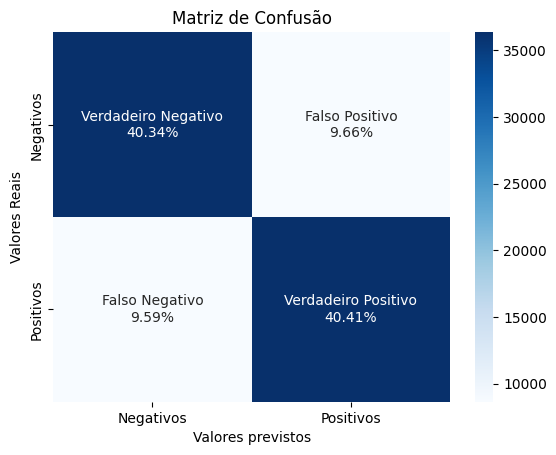

In [ ]:
import re
import pandas as pd
import time
import emoji
import nltk
from nltk.stem import WordNetLemmatizer

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
import numpy as np

# NLTK Downloads
nltk.download('wordnet')

# Dicionário de abreviações
abbreviations = {
    "u": "you",
    "r": "are",
    "btw": "by the way",
    "lol": "laughing out loud",
    # Adicione mais conforme necessário
}

# Função para substituir emojis por palavras
def replace_emoji_with_words(text):
    return emoji.demojize(text)  # Converte emojis para a representação textual como :smile:

# Função para expandir abreviações
def expand_abbreviations(text):
    return " ".join([abbreviations.get(word, word) for word in text.split()])

# Função de pré-processamento
def preprocess(textdata):
    """
    Ajustes e normalização dos textos
    """
    lemmatizer = WordNetLemmatizer()
    processed_text = []

    for text in textdata:
        # Transformações textuais
        text = text.lower()
        text = replace_emoji_with_words(text)  # Substituir emojis por palavras
        text = expand_abbreviations(text)  # Expandir abreviações
        text = re.sub(r"((http|https|www)[^ ]*)", "URL", text)  # Substituir URLs
        text = re.sub(r"@[^\s]+", "USER", text)  # Substituir menções
        text = re.sub(r"[^a-zA-Z0-9\s]", " ", text)  # Remover pontuação
        text = re.sub(r"\s+", " ", text).strip()  # Normalizar espaços

        # Lematização
        tweet_words = [lemmatizer.lemmatize(word) for word in text.split() if len(word) > 1]
        processed_text.append(" ".join(tweet_words))

    return processed_text

# Função: Carregar o dataset
def load_dataset(file_path, sample_size=150000):
    columns = ["sentiment", "ids", "date", "flag", "user", "text"]
    dataset = pd.read_csv(file_path, encoding="ISO-8859-1", names=columns, on_bad_lines="skip")
    dataset = dataset[["sentiment", "text"]].replace(4, 1)  # Corrige a classe de sentimentos

    # Balanceando o dataset
    negative_data = dataset[dataset["sentiment"] == 0].sample(sample_size, random_state=42)
    positive_data = dataset[dataset["sentiment"] == 1].sample(sample_size, random_state=42)

    balanced_dataset = pd.concat([negative_data, positive_data]).sample(frac=1, random_state=42).reset_index(drop=True)
    print(f"Conjunto de dados carregado e balanceado: {len(balanced_dataset)} amostras (50% positivos, 50% negativos).")
    return balanced_dataset

# Função: Treinamento e avaliação dos modelos
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    """
    Treinando múltiplos modelos e avaliando suas performances.
    """
    models = {
        "RandomForest": RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42),
        "BernoulliNB": BernoulliNB(alpha=2),
        "LinearSVC": LinearSVC(),
        "LogisticRegression": LogisticRegression(C=2, max_iter=1000, n_jobs=-1)
    }

    results = {}
    for name, model in models.items():
        print(f"\nTreinando modelo {name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(f"Avaliação para {name}:")
        print(classification_report(y_test, y_pred))
        results[name] = model

    return results

# Função: Plotar matriz de confusão
def plot_confusion_matrix(model, X_test, y_test):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt

    y_pred = model.predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories = ["Negativos", "Positivos"]
    group_names = ["Verdadeiro Negativo", "Falso Positivo", "Falso Negativo", "Verdadeiro Positivo"]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    sns.heatmap(cf_matrix, annot=labels, cmap="Blues", fmt="", xticklabels=categories, yticklabels=categories)
    plt.title("Matriz de Confusão")
    plt.xlabel("Valores previstos")
    plt.ylabel("Valores Reais")
    plt.show()

# Código Principal/Base
if __name__ == "__main__":
    # Carregando e realizando pré-processamento
    dataset = load_dataset("tweetsDatasetReduced.csv")
    text, sentiment = dataset["text"], dataset["sentiment"]

    print("Realizando pré-processamento do texto...")
    start_time = time.time()
    processed_text = preprocess(text)
    print(f"Pré-processamento finalizado em {time.time() - start_time:.2f} segundos.")

    # Divisão de dados
    X_train, X_test, y_train, y_test = train_test_split(processed_text, sentiment, test_size=0.3, random_state=42)
    print(f"Dados divididos: {len(X_train)} amostras de treinamento e {len(X_test)} amostras de teste.")

    # Vetorização
    vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=500000)
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    print("Dados vetorizados.")

    # Treinando e avaliando os modelos
    models = train_and_evaluate_models(X_train, X_test, y_train, y_test)

    # Matriz de confusão
    plot_confusion_matrix(models["LogisticRegression"], X_test, y_test)